# Titanic

Se adjunta un dataset sobre el desastre del Titanic para hacer ejercicios libres.

Algunos ejercicios que puedes llegar a realizar son:

* Ver el número de valores nulos
* Representar el porcentaje de filas con atributos nulos.
* Limpieza de columnas.
* Saber la edad mínima y máxima de las personas del barco.
* Conocer la mediana de las edades.
* Ver los precios (columna `fares`) más altos y bajos.
* Número de pasajeros embarcados (columna `Embarked`).
* Ver la distribución de sexos en las personas embarcadas.



#### Importamos librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#### Leemos el csv y creamos el dataframe

In [3]:
df = pd.read_csv(r"Recursos\titanic.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Tras investigar sobre el conjunto de datos, llegamos a la conclusión siguiente:
* PassengerId: identificador único del pasajero.
* Survived: si el pasajero sobrevivió al naufragio, codificada como 0 (no) y 1 (si).
* Pclass: clase a la que pertenecía el pasajero: 1, 2 o 3.
* Name: nombre del pasajero.
* Sex: sexo del pasajero.
* Age: edad del pasajero.
* SibSp: número de hermanos, hermanas, hermanastros o hermanastras en el barco
* Parch: número de padres e hijos en el barco.
* Ticket: identificador del billete.
* Fare: precio pagado por el billete.
* Cabin: identificador del camarote asignado al pasajero.
* Embarked: puerto en el que embarcó el pasajero.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Vemos los valores nulos y los representamos gráficamente

In [5]:
df.isnull().sum() / len(df) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

##### Representación gráfica

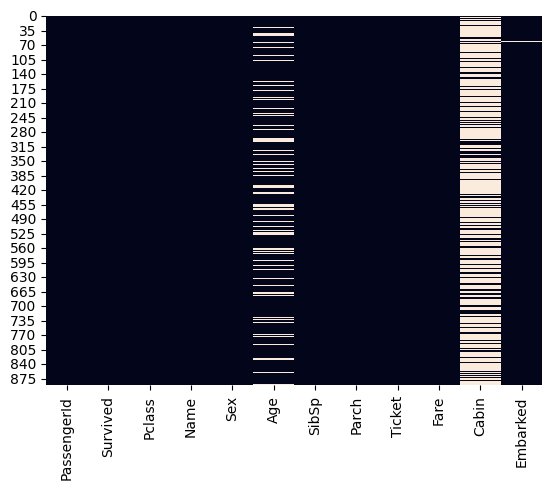

In [6]:
sns.heatmap(df.isnull(), cbar=False);

##### Reparamos los valores nulos de Age usando KNN

In [7]:
df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0])

# Vamos a normalizar MeanCurrentFare para asegurarnos que no tenga un impacto desproporcionado en la distancia 
scaler = StandardScaler()
df_aux = df["Fare"]
df['Fare'] = scaler.fit_transform(df[['Fare']])

In [8]:
# estas son las columnas que quieres como predictores para tu modelo
columnas=['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked',"Age"] #la edad tiene que tenerse en cuenta al predecir, los apellidos es una variable muy random y ruidosa para introducirse

# Aplicamos OneHotEncoder para codificar nuestras variables categóricas 
encoder = OneHotEncoder(drop='first', sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df[columnas]))
df_encoded.columns = encoder.get_feature_names_out(columnas)

In [9]:
# Creamos dos dataframes basados en la presencia de Age
df_encoded['Age'] = df['Age']
df_with_age = df_encoded.dropna(subset=['Age'])
df_without_age = df_encoded[df_encoded['Age'].isna()].drop(columns='Age')

In [10]:
# Dividimos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(df_with_age.drop(columns='Age'), df_with_age['Age'], test_size=0.2, random_state=357)

scores = [219.08405565 122.88157895 223.62027544 135.65153772 167.68399386]
scores = [136.52994217  82.51329496 155.70730219 105.13201404 123.60082807]
scores = [130.4628458   60.18006121 135.48813665 108.51132836 116.9991268 ]
scores = [117.66245815  67.15095137 127.62349945 110.55036469 131.51371228]
scores = [125.76203809  68.63970772 127.35082789 125.38223218 134.64002067]
scores = [127.75953862  76.2862182  126.66201508 128.28372641 138.96856813]


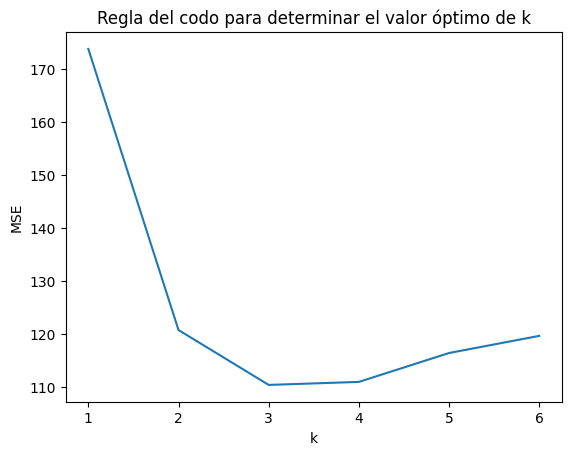

In [11]:
# Lista para almacenar los valores de MSE (Error Cuadrático Medio)
mse = []

# Rango de k para probar
k_range = range(1, 7)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Realizamos la validación cruzada para obtener una medida más robusta del error
    """  estamos tomando el negativo de los valores devueltos para obtener el MSE real. 
         Luego, añadimos la media de estos valores a nuestra lista de MSE para cada valor de k (mse.append(scores.mean())).
    """
    scores = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse.append(scores.mean())
    print(f'scores = {scores}')
    
 
# Graficamos los valores 
plt.plot(k_range, mse)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Regla del codo para determinar el valor óptimo de k')
plt.show()

# Graficamos 

In [12]:
# Determinar el mejor valor de k
best_k = k_range[mse.index(min(mse))]
print(f'Mejor número K: {best_k}')

Mejor número K: 3


In [13]:
# Creamos el modelo KNN con el mejor valor de k
knn = KNeighborsRegressor(n_neighbors=best_k)

# Ajustamos el modelo a los datos sin valores nulos
knn.fit(X_train, y_train)

# Imputamos los valores faltantes en la columna 'Age'
imputed_ages = knn.predict(df_without_age)
df.loc[df['Age'].isna(), 'Age'] = imputed_ages
df["Fare"] = df_aux

In [14]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
LastName         0
dtype: int64

#### Queremos trabajar sobre la variable Survived, por lo tanto sustituiremos el 0 por un "No" y el 1 por un "Si", para tener una mejor lectura de los datos en las representaciones.

In [15]:
df["Survived"].replace([0, 1], ["No", "Si"], inplace=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,Si,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,Si,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,Si,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,No,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Montvila
887,888,Si,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Graham
888,889,No,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,23.0,1,2,W./C. 6607,23.4500,NaN,S,Johnston
889,890,Si,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Behr


#### Comprobamos la distribución de la edad

In [16]:
fig = px.histogram(df,range_x=[0,80], x="Age", nbins=10, text_auto=True, labels={"Age": "Edad"}, log_y=False,template="plotly_dark",width=750, histfunc="count", title="Distribución de la edad")
fig.update_xaxes(tick0=0, dtick=5)
fig.show()

#### ¿Qué porcentaje de personas sobrevivió al titanic?

##### Representamos gráficamente el número de personas que sobrevivió, separándolos además por sexo.

In [17]:
fig = px.histogram(df, x="Survived", nbins=5, text_auto=True, labels={"Survived": "Sobrevivió", "Sex": "Sexo"}, log_y=False,template="plotly_dark",color="Sex",width=750, histfunc="count", title="Nº de supervivientes según el sexo")
fig.show()

##### Calculamos el porcentaje de personas que sobrevivieron, además del porcentaje de hombres y mujeres.

In [18]:
total_survived = np.round(len(df[df["Survived"] == "Si"]) * 100 / len(df["Survived"]), 2)
men_survived = np.round(len(df[df["Survived"] == "Si"][df["Sex"] == "male"]) * 100 / len(df[df["Survived"] == "Si"]), 2)
women_survived = np.round(len(df[df["Survived"] == "Si"][df["Sex"] == "female"]) * 100 / len(df[df["Survived"] == "Si"]), 2)

print(f"El porcentaje de personas que en total sobrevivieron es: {total_survived} \n\rEl porcentaje de hombres que sobrevivieron es de: {men_survived} \n\rEl porcentaje de mujeres que sobrevivieron es de: {women_survived}")

El porcentaje de personas que en total sobrevivieron es: 38.38 
El porcentaje de hombres que sobrevivieron es de: 31.87 
El porcentaje de mujeres que sobrevivieron es de: 68.13


C:\Users\NITROPC\AppData\Local\Temp\ipykernel_8508\1401359089.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_8508\1401359089.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



#### Para estudiar los precios de los billetes y su relación con la supervivencia, pasamos estos datos a Libras actuales

##### Según el Bank of England, una libra esterlina de 1912 hoy día equivale a 95.42 libras.
##### Sin embargo, según fuentes históricas, la inflación acumulada es de aproximadamente 13,299%, por lo que el valor del dinero ha aumentado 132.99 veces.
##### Sabiendo estos datos, calcularemos ambas conversiones y haremos una media entre las dos para poder utilizar estos datos

In [19]:
currentPounds = 95.42
currentInflation = 132.99

df["CurrentFare1"] = df["Fare"] * currentPounds # Creamos una columna en el dataframe con la conversión a libras de hoy día.
df["CurrentFare2"] = df["Fare"] * currentInflation # Creamos una columna en el dataframe con la conversión a libras de hoy día.
df["MeanCurrentFare"] = df["Fare"]

for i in range(len(df)):
    df["MeanCurrentFare"][i] = (df["CurrentFare1"][i] + df["CurrentFare2"][i]) / 2

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_8508\1536979280.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
df.drop(columns=["CurrentFare1", "CurrentFare2"], inplace=True)

##### Pasamos la media a euros

In [21]:
exchange_rate = 1.16
df["MeanCurrentFare"] = df["MeanCurrentFare"].apply(lambda x: np.round(x*exchange_rate, 2))

#### Comparamos el valor del billete medio con la supervivencia del pasajero.

##### Comprobamos primero el precio mínimo y máximo del billete

In [22]:
print(f"El precio máximo del billete es: " + str(df["MeanCurrentFare"].max()))
print(f"El precio mínimo del billete es: "+ str(df[df["MeanCurrentFare"] > 0]["MeanCurrentFare"].min())) # Excluimos el 0 ya que serían billetes de la tripulación o regalos.

El precio máximo del billete es: 67872.25
El precio mínimo del billete es: 531.57


##### Relacionamos el precio medio del billete con la supervivencia

In [23]:
fig = px.histogram(df, x="Survived",y="MeanCurrentFare", nbins=5, text_auto=True, labels={"Survived": "Supervivencia", "MeanCurrentFare": "Billete en €"}, log_y=False,template="plotly_dark",color="Survived",width=750, histfunc="avg", title="Relación precio billete/supervivencia")
fig.show()

In [33]:
px.box(df, hover_name="Name", notched=True, x="MeanCurrentFare", log_x=True, boxmode="group", color="Survived", color_discrete_sequence=["firebrick", "seagreen"], labels={"Survived": "Sobrevivió", "MeanCurrentFare": "Precio del billete"}, template="plotly_dark")

##### Según este gráfico, las personas que acabaron sobreviviendo pagaron de media más por el precio del billete. Esto puede deberse a:
* La posición de los camarotes en el barco
* Las personas que, al ser trabajadores, no pagaron su billete (la media puede verse afectada)

##### Viendo la casualidad de que haya varias parejas en los outliers, ¿cuántas familias se vieron afectadas por este desastre?

In [ ]:
df_aux = df[df["LastName"].duplicated(keep=False)] # Creo un dataframe auxiliar que solo contiene los datos de los apellidos duplicados, es decir, las familias.

In [ ]:
fig = px.scatter(df_aux, x="LastName", y="Age", color='Survived', template="plotly_dark"
                 ,labels={"LastName": "Apellidos", "Age": "Edad", "Survived": "Sobrevivió"}
                 ,size="Age"
                 ,width=3500
                 ,hover_name=df_aux["Name"]
                 )
fig.update_layout(title=dict(text="Familias afectadas", font=dict(size=40, family="Courier", color="white")))

fig.show()

#### ¿Tiene relación el coste del billete con la clase del pasajero? ("Fare" y "Pclass")

In [ ]:
fig = px.histogram(df, x="Pclass",y="MeanCurrentFare",labels={"Pclass": "Clase del pasajero", "MeanCurrentFare": "Billete"}, text_auto=True, nbins=5, log_y=False,template="plotly_dark",color="Pclass",width=750, histfunc="avg", title="Clase del pasajero en relación al precio del billete")
fig.show()

#### Sabiendo que la clase está directamente relacionada con el precio del billete, podemos relacionar el sexo del mismo y su poder adquisitivo (clase) con si llegó a sobrevivir o no.

##### Calculamos el porcentaje que representa cada clase de pasajero (1, 2 o 3)

In [ ]:
pClass1 = np.round(len(df[df["Pclass"] == 1]) * 100 / len(df), 2)
pClass2 = np.round(len(df[df["Pclass"] == 2]) * 100 / len(df), 2)
pClass3 = np.round(len(df[df["Pclass"] == 3]) * 100 / len(df), 2)

print(f"El porcentaje de personas según su clase de pasajero es: \n- Clase 1: {pClass1}\n- Clase 2: {pClass2}\n- Clase 3: {pClass3}")

El porcentaje de personas según su clase de pasajero es: 
- Clase 1: 24.24
- Clase 2: 20.65
- Clase 3: 55.11


##### Representamos los datos

In [ ]:
# Calculamos el porcentaje de personas que sobrevivieron según el Pclass
pClass1 = np.round(len(df[df["Pclass"] == 1][df["Survived"] == "Si"]) * 100 / len(df[df["Pclass"] == 1]), 2)
pClass2 = np.round(len(df[df["Pclass"] == 2][df["Survived"] == "Si"]) * 100 / len(df[df["Pclass"] == 2]), 2)
pClass3 = np.round(len(df[df["Pclass"] == 3][df["Survived"] == "Si"]) * 100 / len(df[df["Pclass"] == 3]), 2)

print(f"El porcentaje de personas que sobrevivieron según su clase de pasajero es: \n- Clase 1: {pClass1}\n- Clase 2: {pClass2}\n- Clase 3: {pClass3}")

# Calculamos el porcentaje de personas que NO sobrevivieron según el Pclass
pClass1 = np.round(len(df[df["Pclass"] == 1][df["Survived"] == "No"]) * 100 / len(df[df["Pclass"] == 1]), 2)
pClass2 = np.round(len(df[df["Pclass"] == 2][df["Survived"] == "No"]) * 100 / len(df[df["Pclass"] == 2]), 2)
pClass3 = np.round(len(df[df["Pclass"] == 3][df["Survived"] == "No"]) * 100 / len(df[df["Pclass"] == 3]), 2)

print(f"El porcentaje de personas que no sobrevivieron según su clase de pasajero es: \n- Clase 1: {pClass1}\n- Clase 2: {pClass2}\n- Clase 3: {pClass3}")

El porcentaje de personas que sobrevivieron según su clase de pasajero es: 
- Clase 1: 62.96
- Clase 2: 47.28
- Clase 3: 24.24
El porcentaje de personas que no sobrevivieron según su clase de pasajero es: 
- Clase 1: 37.04
- Clase 2: 52.72
- Clase 3: 75.76


C:\Users\NITROPC\AppData\Local\Temp\ipykernel_3196\1183030534.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_3196\1183030534.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_3196\1183030534.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_3196\1183030534.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_3196\1183030534.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\NITROPC\AppData\Local\Temp\ipykernel_3196\1183030534.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
fig = px.parallel_categories(df, dimensions=["Sex", "Pclass", "Survived"]
                             , range_color=[1, 3], color="Pclass"
                             , title="Relación entre el sexo, la clase del pasajero y si sobrevivió o no"
                             , template="plotly_dark", color_continuous_scale=px.colors.sequential.Agsunset)
fig.show()